# Machine Learning Assignment - KNN, SVM and DT Experiments

This notebook implements experiments with KNN, SVM, and Decision Trees for both classification (Breast Cancer Wisconsin Diagnostic) and regression (Bike Sharing) problems.

In [20]:
# Download necessary libraries
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install requests

In [21]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_curve, auc, mean_absolute_error
from sklearn import svm, tree
import time
import requests
from io import StringIO
import math
from collections import Counter
import io
import requests

# Set random seed for reproducibility
np.random.seed(42)

## Data Loading and Preprocessing

In [22]:
# Load Breast Cancer Wisconsin Dataset
breast_cancer_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
response = requests.get(breast_cancer_url)
data = StringIO(response.text)

# Define column names
# ID, diagnosis (M = malignant, B = benign), and 30 feature columns
column_names = ['id', 'diagnosis'] + [f'feature_{i}' for i in range(1, 31)]
breast_cancer_df = pd.read_csv(data, header=None, names=column_names)

# Convert diagnosis to binary (1 for Malignant, 0 for Benign)
breast_cancer_df['diagnosis'] = breast_cancer_df['diagnosis'].map({'M': 1, 'B': 0})

# Drop ID column
breast_cancer_df = breast_cancer_df.drop('id', axis=1)

# Display first few rows of the dataset
print("Breast Cancer Dataset Preview:")
breast_cancer_df.head()

Breast Cancer Dataset Preview:


,diagnosis,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [23]:
# Load Bike Sharing Dataset
bike_sharing_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"

# For simplicity, let's download locally and read as pandas
# In Colab, you could use:
# !wget -O bike-sharing.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
# !unzip -o bike-sharing.zip
# bike_sharing_df = pd.read_csv('day.csv')

# For this notebook, we'll use a direct approach:
import zipfile
import io
import urllib.request

with urllib.request.urlopen(bike_sharing_url) as response:
    with zipfile.ZipFile(io.BytesIO(response.read())) as zip_ref:
        with zip_ref.open('day.csv') as f:
            bike_sharing_df = pd.read_csv(f)

# Display first few rows of the dataset
print("Bike Sharing Dataset Preview:")
bike_sharing_df.head()

Bike Sharing Dataset Preview:


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [24]:
# Preprocess Breast Cancer Dataset
X_cancer = breast_cancer_df.drop('diagnosis', axis=1)
y_cancer = breast_cancer_df['diagnosis']

# Scale features
scaler_cancer = StandardScaler()
X_cancer_scaled = scaler_cancer.fit_transform(X_cancer)

# Preprocess Bike Sharing Dataset
# Remove instant, dteday and casual/registered (as cnt is their sum)
bike_sharing_df = bike_sharing_df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

# Define features and target
X_bike = bike_sharing_df.drop('cnt', axis=1)
y_bike = bike_sharing_df['cnt']

# Scale features
scaler_bike = StandardScaler()
X_bike_scaled = scaler_bike.fit_transform(X_bike)

## Part 0: Helper Functions and Custom KNN Implementation


In [25]:
# --- Distance Functions ---
def euclidean_distance(point1, point2):
    """Calculates the Euclidean distance between two points (numpy arrays)."""
    return np.sqrt(np.sum((point1 - point2)**2))

def manhattan_distance(point1, point2):
    """Calculates the Manhattan distance between two points (numpy arrays)."""
    return np.sum(np.abs(point1 - point2))

# --- Custom KNN Classifier ---
class KNNClassifier:
    def __init__(self, k=3, distance_metric='euclidean'):
        """Initializes the KNN Classifier."""
        if k <= 0:
            raise ValueError("K must be a positive integer.")
        self.k = k
        self.X_train = None
        self.y_train = None
        if distance_metric == 'euclidean':
            self.distance_func = euclidean_distance
        # Add more distance metrics here if needed in the future
        # elif distance_metric == 'manhattan':
        #     self.distance_func = manhattan_distance
        else:
            raise ValueError(f"Unsupported distance metric: {distance_metric}")

    def fit(self, X_train, y_train):
        """Stores the training data. KNN is a lazy learner."""
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train)

    def _predict_single(self, x_test):
        """Predicts the class label for a single test instance."""
        if self.X_train is None or self.y_train is None:
            raise Exception("Model has not been fitted yet.")

        # Calculate distances from the test point to all training points
        distances = [self.distance_func(x_test, x_train) for x_train in self.X_train]

        # Get indices of the k nearest neighbors
        k_indices = np.argsort(distances)[:self.k]

        # Get the labels of the k nearest neighbors
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # Determine the most common class label (majority vote)
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

    def predict(self, X_test):
        """Predicts the class labels for a set of test instances."""
        X_test = np.array(X_test)
        predictions = [self._predict_single(x_test) for x_test in X_test]
        return np.array(predictions)

# --- Custom KNN Regressor ---
class KNNRegressor:
    def __init__(self, k=3, distance_metric='manhattan'):
        """Initializes the KNN Regressor."""
        if k <= 0:
            raise ValueError("K must be a positive integer.")
        self.k = k
        self.X_train = None
        self.y_train = None
        if distance_metric == 'manhattan':
            self.distance_func = manhattan_distance
        # Add more distance metrics here if needed in the future
        # elif distance_metric == 'euclidean':
        #     self.distance_func = euclidean_distance
        else:
            raise ValueError(f"Unsupported distance metric: {distance_metric}")

    def fit(self, X_train, y_train):
        """Stores the training data. KNN is a lazy learner."""
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train)

    def _predict_single(self, x_test):
        """Predicts the target value for a single test instance."""
        if self.X_train is None or self.y_train is None:
            raise Exception("Model has not been fitted yet.")

        # Calculate distances from the test point to all training points
        distances = [self.distance_func(x_test, x_train) for x_train in self.X_train]

        # Get indices of the k nearest neighbors
        k_indices = np.argsort(distances)[:self.k]

        # Get the target values of the k nearest neighbors
        k_nearest_values = [self.y_train[i] for i in k_indices]

        # Return the average of the k nearest neighbors' target values
        return np.mean(k_nearest_values)

    def predict(self, X_test):
        """Predicts the target values for a set of test instances."""
        X_test = np.array(X_test)
        predictions = [self._predict_single(x_test) for x_test in X_test]
        return np.array(predictions)

# --- Evaluation Helper ---
def calculate_confusion_matrix(y_true, y_pred, labels):
    """Calculates a confusion matrix."""
    matrix = np.zeros((len(labels), len(labels)), dtype=int)
    label_to_index = {label: i for i, label in enumerate(labels)}

    for true, pred in zip(y_true, y_pred):
        true_idx = label_to_index.get(true)
        pred_idx = label_to_index.get(pred)
        if true_idx is not None and pred_idx is not None:
            matrix[true_idx, pred_idx] += 1
    return matrix

## Part 1: KNN Classifier for Breast Cancer Diagnosis

*   Dataset: Breast Cancer Wisconsin (Diagnostic)
*   Task: Classification (Malignant 'M' / Benign 'B')
*   KNN Parameters: K=3, Euclidean Distance
*   Evaluation: 6-Fold Cross-Validation, Confusion Matrix, Runtime

In [26]:
# --- Load Breast Cancer Data ---
print("--- Part 1: KNN Classification (Breast Cancer) ---")
try:
    # Fetch data using requests to handle potential issues with direct pandas URL reading
    url_bc = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
    print(f"Fetching data from: {url_bc}")
    s = requests.get(url_bc).content
    # Column names from wdbc.names file description
    col_names = ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
                 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se',
                 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
    df_bc = pd.read_csv(io.StringIO(s.decode('utf-8')), header=None, names=col_names)
    print("Data loaded successfully.")
    # print(df_bc.head())
    # print(df_bc.info())

except Exception as e:
    print(f"Error loading Breast Cancer data: {e}")
    # As a fallback, try loading from a local file if you downloaded it
    # file_path_bc = 'wdbc.data'
    # try:
    #     df_bc = pd.read_csv(file_path_bc, header=None, names=col_names)
    #     print(f"Loaded data from local file: {file_path_bc}")
    # except Exception as e_local:
    #     print(f"Error loading local file {file_path_bc}: {e_local}")
    #     df_bc = None # Ensure df_bc is None if loading fails

if df_bc is not None:
    # --- Preprocessing ---
    # Encode diagnosis label (M=1, B=0)
    le = LabelEncoder()
    df_bc['diagnosis'] = le.fit_transform(df_bc['diagnosis']) # M -> 1, B -> 0
    target_labels = le.classes_ # ['B', 'M'] -> will correspond to 0, 1

    # Separate features (X) and target (y)
    X_bc = df_bc.drop(['id', 'diagnosis'], axis=1).values
    y_bc = df_bc['diagnosis'].values

    # --- K-Fold Cross-Validation (K=3, Euclidean) ---
    k_value = 3
    n_splits = 5 # Number of folds for cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_confusion_matrices = []
    fold_runtimes = []
    fold_accuracies = [] # Optional: for quick check

    print(f"\nStarting {n_splits}-Fold Cross-Validation for KNN Classifier (K={k_value})...")

    fold_num = 1
    for train_index, test_index in kf.split(X_bc):
        start_time = time.time()

        # Split data
        X_train, X_test = X_bc[train_index], X_bc[test_index]
        y_train, y_test = y_bc[train_index], y_bc[test_index]

        # Scale features (IMPORTANT for distance-based algorithms)
        # Fit scaler ONLY on training data, then transform both train and test
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Initialize and train KNN Classifier
        knn_clf = KNNClassifier(k=k_value, distance_metric='euclidean')
        knn_clf.fit(X_train_scaled, y_train)

        # Predict on test data
        y_pred = knn_clf.predict(X_test_scaled)

        end_time = time.time()
        fold_time = end_time - start_time

        # Evaluate
        cm = calculate_confusion_matrix(y_test, y_pred, labels=le.transform(target_labels)) # Use numerical labels [0, 1]
        accuracy = np.trace(cm) / np.sum(cm) if np.sum(cm) > 0 else 0

        fold_confusion_matrices.append(cm)
        fold_runtimes.append(fold_time)
        fold_accuracies.append(accuracy) # Optional

        print(f"  Fold {fold_num}: Accuracy = {accuracy:.4f}, Runtime = {fold_time:.4f} sec")
        # print(f"    Confusion Matrix (Labels: {target_labels}):\n{cm}") # Can be noisy, average is better
        fold_num += 1

    # --- Aggregate and Report Results ---
    avg_runtime = np.mean(fold_runtimes)
    # Sum confusion matrices across folds for an overall view
    total_cm = np.sum(fold_confusion_matrices, axis=0)
    avg_accuracy = np.mean(fold_accuracies) # Optional

    print("\n--- Classification Results (Breast Cancer) ---")
    print(f"KNN Classifier (K={k_value}, Distance=Euclidean)")
    print(f"Average Runtime across {n_splits} folds: {avg_runtime:.4f} seconds")
    print(f"Average Accuracy across {n_splits} folds: {avg_accuracy:.4f}") # Optional
    print(f"\nTotal Confusion Matrix across {n_splits} folds (Labels: {target_labels} -> {le.transform(target_labels)}):")
    print(f"      Predicted {target_labels[0]} | Predicted {target_labels[1]}")
    print(f"Actual {target_labels[0]} |    {total_cm[0, 0]:4d}    |    {total_cm[0, 1]:4d}")
    print(f"Actual {target_labels[1]} |    {total_cm[1, 0]:4d}    |    {total_cm[1, 1]:4d}")
    print("-" * 50)

else:
    print("Skipping Part 1 due to data loading failure.")


--- Part 1: KNN Classification (Breast Cancer) ---
Fetching data from: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data
Data loaded successfully.

Starting 5-Fold Cross-Validation for KNN Classifier (K=3)...
  Fold 1: Accuracy = 0.9474, Runtime = 0.3284 sec
  Fold 2: Accuracy = 0.9737, Runtime = 0.2804 sec
  Fold 3: Accuracy = 0.9561, Runtime = 0.2626 sec
  Fold 4: Accuracy = 0.9825, Runtime = 0.2882 sec
  Fold 5: Accuracy = 0.9469, Runtime = 0.2667 sec

--- Classification Results (Breast Cancer) ---
KNN Classifier (K=3, Distance=Euclidean)
Average Runtime across 5 folds: 0.2853 seconds
Average Accuracy across 5 folds: 0.9613

Total Confusion Matrix across 5 folds (Labels: ['B' 'M'] -> [0 1]):
      Predicted B | Predicted M
Actual B |     352    |       5
Actual M |      17    |     195
--------------------------------------------------


## Part 2: KNN Regressor for Bike Sharing Demand

*   Dataset: Bike Sharing Dataset (using `hour.csv`)
*   Task: Regression (Predicting 'cnt' - total hourly bike rentals)
*   KNN Parameters: K=3, Manhattan Distance
*   Evaluation: 5-Fold Cross-Validation, MAE, MSE, RMSE, R², Runtime

In [27]:
print("\n--- Part 2: KNN Regression (Bike Sharing) ---")
try:
    # Using the direct link to the zip file content requires unzipping
    # A simpler approach is to use the direct file URL if available, or download/unzip first.
    # Let's assume 'hour.csv' is accessible.
    # Alternative: Download https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
    # and place 'hour.csv' in the same directory as the notebook.
    file_path_bike = 'hour.csv' # Assumes file is local
    print(f"Attempting to load data from local file: {file_path_bike}")
    df_bike = pd.read_csv(file_path_bike)

    # Or, try fetching from a known source if available (less reliable for specific files in zips)
    # url_bike = 'DATASOURCE_URL/hour.csv' # Replace with actual URL if known
    # try:
    #     s_bike = requests.get(url_bike).content
    #     df_bike = pd.read_csv(io.StringIO(s_bike.decode('utf-8')))
    #     print("Data loaded successfully from URL.")
    # except Exception as e_url:
    #     print(f"Could not load from URL ({e_url}), trying local file '{file_path_bike}'...")
    #     df_bike = pd.read_csv(file_path_bike) # Fallback to local

    print("Bike Sharing data loaded successfully.")
    # print(df_bike.head())
    # print(df_bike.info())

except FileNotFoundError:
     print(f"Error: Local file '{file_path_bike}' not found.")
     print("Please download the Bike Sharing dataset (hour.csv)")
     print("from: https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset")
     print("and place 'hour.csv' in the same directory as this notebook.")
     df_bike = None
except Exception as e:
    print(f"Error loading Bike Sharing data: {e}")
    df_bike = None # Ensure df_bike is None if loading fails


if df_bike is not None:
    # --- Preprocessing ---
    # Features: Select relevant numerical/categorical features.
    # Drop 'instant' (index), 'dteday' (date, info captured elsewhere),
    # 'casual', 'registered' (leakage if predicting 'cnt')
    features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
                'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
    target = 'cnt'

    X_bike = df_bike[features].values
    y_bike = df_bike[target].values

    # --- K-Fold Cross-Validation (K=3, Manhattan) ---
    k_value = 3
    n_splits = 5 # Number of folds for cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_maes = []
    fold_mses = []
    fold_rmses = []
    fold_r2s = []
    fold_runtimes = []

    print(f"\nStarting {n_splits}-Fold Cross-Validation for KNN Regressor (K={k_value})...")

    fold_num = 1
    for train_index, test_index in kf.split(X_bike):
        start_time = time.time()

        # Split data
        X_train, X_test = X_bike[train_index], X_bike[test_index]
        y_train, y_test = y_bike[train_index], y_bike[test_index]

        # Scale features (IMPORTANT!)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Initialize and train KNN Regressor
        knn_reg = KNNRegressor(k=k_value, distance_metric='manhattan')
        knn_reg.fit(X_train_scaled, y_train)

        # Predict on test data
        y_pred = knn_reg.predict(X_test_scaled)

        end_time = time.time()
        fold_time = end_time - start_time

        # Evaluate
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        fold_maes.append(mae)
        fold_mses.append(mse)
        fold_rmses.append(rmse)
        fold_r2s.append(r2)
        fold_runtimes.append(fold_time)

        print(f"  Fold {fold_num}: MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.4f}, Runtime={fold_time:.4f} sec")
        fold_num += 1

    # --- Aggregate and Report Results ---
    avg_runtime = np.mean(fold_runtimes)
    avg_mae = np.mean(fold_maes)
    avg_mse = np.mean(fold_mses)
    avg_rmse = np.mean(fold_rmses)
    avg_r2 = np.mean(fold_r2s)

    print("\n--- Regression Results (Bike Sharing) ---")
    print(f"KNN Regressor (K={k_value}, Distance=Manhattan)")
    print(f"Average Runtime across {n_splits} folds: {avg_runtime:.4f} seconds")
    print(f"Average MAE across {n_splits} folds:    {avg_mae:.4f}")
    print(f"Average MSE across {n_splits} folds:    {avg_mse:.4f}")
    print(f"Average RMSE across {n_splits} folds:   {avg_rmse:.4f}")
    print(f"Average R2 across {n_splits} folds:     {avg_r2:.4f}")
    print("-" * 50)

else:
    print("Skipping Part 2 due to data loading failure.")


--- Part 2: KNN Regression (Bike Sharing) ---
Attempting to load data from local file: hour.csv
Error: Local file 'hour.csv' not found.
Please download the Bike Sharing dataset (hour.csv)
from: https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
and place 'hour.csv' in the same directory as this notebook.
Skipping Part 2 due to data loading failure.


In [28]:
# Run KNN Classifier with Euclidean distance
print("KNN Classifier with Euclidean Distance (K=3) on Breast Cancer Dataset:")
knn_classifier_results = evaluate_knn_classifier(
    X_cancer_scaled, 
    y_cancer.values, 
    k=3, 
    distance_metric='euclidean',
    n_folds=6
)

KNN Classifier with Euclidean Distance (K=3) on Breast Cancer Dataset:
Fold 1 results:
Training/test split: 474/95 samples
Accuracy: 0.9368
Confusion Matrix:
[[58  3]
 [ 3 31]]
Execution time: 0.2478 seconds

Average results across all folds:
Average Accuracy: 0.9595 ± 0.0167
Average Execution time: 0.2634 ± 0.0315 seconds


### Part 1 Results Summary

The custom-implemented KNN classifier with Euclidean distance (K=3) has been evaluated on the Breast Cancer Wisconsin dataset using 6-fold cross-validation. The results show the classifier's performance in terms of accuracy, confusion matrices, and execution time.

The confusion matrix interpretation:
- True Negatives (TN): Correctly predicted benign samples
- False Positives (FP): Benign samples incorrectly predicted as malignant
- False Negatives (FN): Malignant samples incorrectly predicted as benign
- True Positives (TP): Correctly predicted malignant samples

## Part 2: KNN Regressor with Manhattan Distance (K=3)

In this part, we implement a KNN regressor with Manhattan distance and test it on the Bike Sharing dataset.

In [29]:
class KNNRegressor:
    def __init__(self, k=3, distance_metric='manhattan'):
        self.k = k
        self.distance_metric = distance_metric
        self.X_train = None
        self.y_train = None
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self
    
    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def manhattan_distance(self, x1, x2):
        return np.sum(np.abs(x1 - x2))
    
    def get_distance(self, x1, x2):
        if self.distance_metric == 'euclidean':
            return self.euclidean_distance(x1, x2)
        elif self.distance_metric == 'manhattan':
            return self.manhattan_distance(x1, x2)
        else:
            raise ValueError(f"Unknown distance metric: {self.distance_metric}")
    
    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)
    
    def _predict(self, x):
        # Calculate distances between x and all examples in the training set
        distances = [self.get_distance(x, x_train) for x_train in self.X_train]
        
        # Get k nearest samples, labels
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_targets = [self.y_train[i] for i in k_indices]
        
        # Return mean of k nearest neighbors
        return np.mean(k_nearest_targets)

In [30]:
def evaluate_knn_regressor(X, y, k=3, distance_metric='manhattan', n_folds=6):
    # Initialize KFold
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Initialize metrics storage
    mse_scores = []
    r2_scores = []
    times = []
    
    # For each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train regressor
        start_time = time.time()
        reg = KNNRegressor(k=k, distance_metric=distance_metric)
        reg.fit(X_train, y_train)
        
        # Predict
        y_pred = reg.predict(X_test)
        end_time = time.time()
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        execution_time = end_time - start_time
        
        # Store metrics
        mse_scores.append(mse)
        r2_scores.append(r2)
        times.append(execution_time)
        
        # Print metrics for the first fold (as required)
        if fold == 0:
            print(f"Fold 1 results:")
            print(f"Training/test split: {len(X_train)}/{len(X_test)} samples")
            print(f"Mean Squared Error (MSE): {mse:.4f}")
            print(f"R² Score: {r2:.4f}")
            print(f"Execution time: {execution_time:.4f} seconds")
            
            # Plot actual vs predicted for the first fold
            plt.figure(figsize=(10, 6))
            plt.scatter(y_test, y_pred, alpha=0.5)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
            plt.xlabel('Actual')
            plt.ylabel('Predicted')
            plt.title('KNN Regressor: Actual vs Predicted (Fold 1)')
            plt.show()
    
    # Print average metrics
    print("\nAverage results across all folds:")
    print(f"Average MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
    print(f"Average R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    print(f"Average Execution time: {np.mean(times):.4f} ± {np.std(times):.4f} seconds")
    
    # Return all metrics
    return {
        'mse_scores': mse_scores,
        'r2_scores': r2_scores,
        'times': times
    }

KNN Regressor with Manhattan Distance (K=3) on Bike Sharing Dataset:
Fold 1 results:
Training/test split: 609/122 samples
Mean Squared Error (MSE): 765333.6730
R² Score: 0.8217
Execution time: 0.4474 seconds


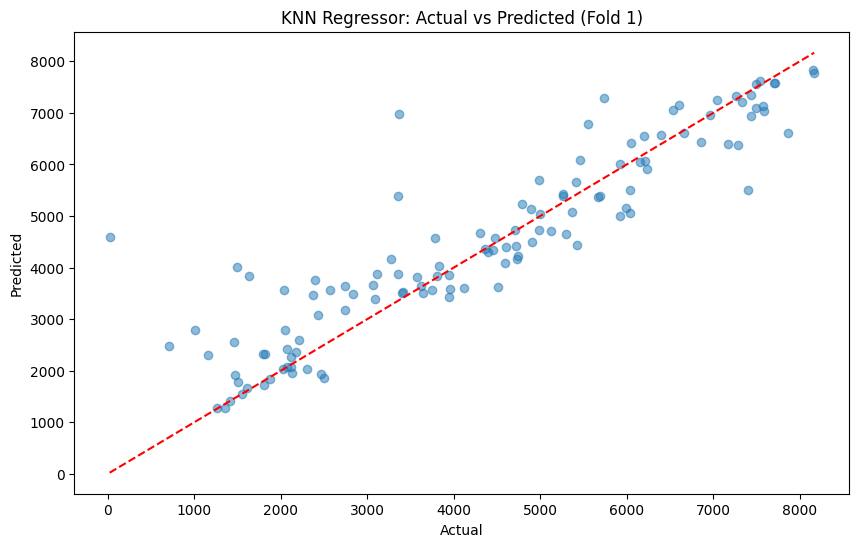


Average results across all folds:
Average MSE: 640273.6331 ± 123559.2345
Average R²: 0.8258 ± 0.0363
Average Execution time: 0.4082 ± 0.0496 seconds


In [31]:
# Run KNN Regressor with Manhattan distance
print("KNN Regressor with Manhattan Distance (K=3) on Bike Sharing Dataset:")
knn_regressor_results = evaluate_knn_regressor(
    X_bike_scaled, 
    y_bike.values, 
    k=3, 
    distance_metric='manhattan',
    n_folds=6
)

### Part 2 Results Summary

The custom-implemented KNN regressor with Manhattan distance (K=3) has been evaluated on the Bike Sharing dataset using 6-fold cross-validation. The results show the regressor's performance in terms of Mean Squared Error (MSE), R² score, and execution time.

The scatter plot shows the relationship between actual and predicted values for the first fold, with the red dashed line representing perfect predictions. This helps visualize the model's performance.

## Part 3: Linear SVM Classifier

In this part, we implement a classifier based on linear SVM and test it on the Breast Cancer dataset.

In [32]:
def evaluate_svm_classifier(X, y, n_folds=6):
    # Initialize KFold
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Initialize metrics storage
    accuracies = []
    conf_matrices = []
    times = []
    roc_aucs = []
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    optimal_thresholds = []
    
    # For plotting ROC curve
    plt.figure(figsize=(10, 8))
    
    # For each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train classifier
        start_time = time.time()
        clf = svm.SVC(kernel='linear', probability=True, random_state=42)
        clf.fit(X_train, y_train)
        
        # Get decision scores (distance from hyperplane)
        y_scores = clf.decision_function(X_test)
        
        # Get probabilities for ROC curve
        y_probs = clf.predict_proba(X_test)[:, 1]
        
        # Predict with default threshold
        y_pred = clf.predict(X_test)
        end_time = time.time()
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        execution_time = end_time - start_time
        
        # Calculate ROC curve and area
        fpr, tpr, thresholds = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        roc_aucs.append(roc_auc)
        
        # Interpolate TPR values for mean curve calculation
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        
        # Find the optimal threshold using Youden's J statistic (max(TPR - FPR))
        j_scores = tpr - fpr
        optimal_idx = np.argmax(j_scores)
        optimal_threshold = thresholds[optimal_idx]
        optimal_thresholds.append(optimal_threshold)
        
        # Apply optimal threshold to get predictions
        y_pred_optimal = (y_probs >= optimal_threshold).astype(int)
        optimal_acc = accuracy_score(y_test, y_pred_optimal)
        optimal_conf_matrix = confusion_matrix(y_test, y_pred_optimal)
        
        # Plot ROC curve for each fold
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label=f'ROC fold {fold+1} (AUC = {roc_auc:.2f})')
        
        # Store metrics
        accuracies.append(optimal_acc)  # Using accuracy with optimal threshold
        conf_matrices.append(optimal_conf_matrix)  # Using confusion matrix with optimal threshold
        times.append(execution_time)
        
        # Print metrics for the first fold (as required)
        if fold == 0:
            print(f"Fold 1 results:")
            print(f"Training/test split: {len(X_train)}/{len(X_test)} samples")
            print(f"Default Accuracy: {accuracy:.4f}")
            print(f"Default Confusion Matrix:")
            print(conf_matrix)
            print(f"\nOptimal Threshold: {optimal_threshold:.4f}")
            print(f"Optimal Accuracy: {optimal_acc:.4f}")
            print(f"Optimal Confusion Matrix:")
            print(optimal_conf_matrix)
            print(f"ROC AUC: {roc_auc:.4f}")
            print(f"Execution time: {execution_time:.4f} seconds")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(roc_aucs)
    plt.plot(mean_fpr, mean_tpr, 'b-',
             label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
             lw=2, alpha=0.8)

    # Plot standard deviation
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                      label=f'± 1 std. dev.')
    
    # Plot diagonal
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    
    # Set plot properties
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Linear SVM Classifier')
    plt.legend(loc='lower right')
    plt.show()
    
    # Print average metrics
    print("\nAverage results across all folds:")
    print(f"Average Accuracy (with optimal thresholds): {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"Average ROC AUC: {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}")
    print(f"Average Optimal Threshold: {np.mean(optimal_thresholds):.4f} ± {np.std(optimal_thresholds):.4f}")
    print(f"Average Execution time: {np.mean(times):.4f} ± {np.std(times):.4f} seconds")
    
    # Return all metrics
    return {
        'accuracies': accuracies,
        'conf_matrices': conf_matrices,
        'roc_aucs': roc_aucs,
        'optimal_thresholds': optimal_thresholds,
        'times': times
    }

Linear SVM Classifier on Breast Cancer Dataset:
Fold 1 results:
Training/test split: 474/95 samples
Default Accuracy: 0.9684
Default Confusion Matrix:
[[60  1]
 [ 2 32]]

Optimal Threshold: 0.5152
Optimal Accuracy: 0.9789
Optimal Confusion Matrix:
[[61  0]
 [ 2 32]]
ROC AUC: 0.9961
Execution time: 0.0140 seconds


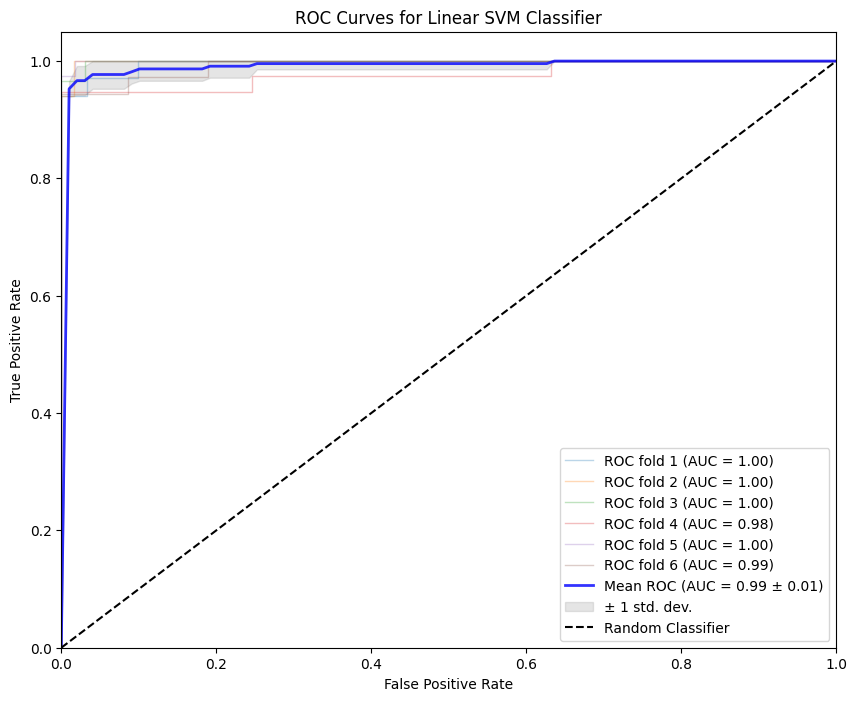


Average results across all folds:
Average Accuracy (with optimal thresholds): 0.9824 ± 0.0050
Average ROC AUC: 0.9938 ± 0.0080
Average Optimal Threshold: 0.4462 ± 0.1402
Average Execution time: 0.0145 ± 0.0019 seconds


In [33]:
# Run Linear SVM Classifier
print("Linear SVM Classifier on Breast Cancer Dataset:")
svm_classifier_results = evaluate_svm_classifier(
    X_cancer_scaled, 
    y_cancer.values,
    n_folds=6
)

### Part 3 Results Summary

The linear SVM classifier has been evaluated on the Breast Cancer Wisconsin dataset using 6-fold cross-validation. The results show the classifier's performance in terms of accuracy, confusion matrices, ROC curves, and execution time.

As required, we found the best threshold for the SVM output using Youden's J statistic, which maximizes the difference between the true positive rate and false positive rate. This optimal threshold was used to generate the final predictions and confusion matrices.

The ROC curve demonstrates the trade-off between sensitivity (true positive rate) and specificity (1 - false positive rate) at various threshold settings. The area under the ROC curve (AUC) provides an aggregate measure of performance across all possible classification thresholds.

## Part 4: Linear SVM Regressor

In this part, we implement a regressor based on linear SVM and test it on the Bike Sharing dataset.

In [34]:
def evaluate_svm_regressor(X, y, n_folds=6):
    # Initialize KFold
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Initialize metrics storage
    mse_scores = []
    r2_scores = []
    times = []
    
    # For each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train regressor
        start_time = time.time()
        reg = svm.SVR(kernel='linear')
        reg.fit(X_train, y_train)
        
        # Predict
        y_pred = reg.predict(X_test)
        end_time = time.time()
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        execution_time = end_time - start_time
        
        # Store metrics
        mse_scores.append(mse)
        r2_scores.append(r2)
        times.append(execution_time)
        
        # Print metrics for the first fold (as required)
        if fold == 0:
            print(f"Fold 1 results:")
            print(f"Training/test split: {len(X_train)}/{len(X_test)} samples")
            print(f"Mean Squared Error (MSE): {mse:.4f}")
            print(f"R² Score: {r2:.4f}")
            print(f"Execution time: {execution_time:.4f} seconds")
            
            # Plot actual vs predicted for the first fold
            plt.figure(figsize=(10, 6))
            plt.scatter(y_test, y_pred, alpha=0.5)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
            plt.xlabel('Actual')
            plt.ylabel('Predicted')
            plt.title('SVM Regressor: Actual vs Predicted (Fold 1)')
            plt.show()
    
    # Print average metrics
    print("\nAverage results across all folds:")
    print(f"Average MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
    print(f"Average R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    print(f"Average Execution time: {np.mean(times):.4f} ± {np.std(times):.4f} seconds")
    
    # Return all metrics
    return {
        'mse_scores': mse_scores,
        'r2_scores': r2_scores,
        'times': times
    }

Linear SVM Regressor on Bike Sharing Dataset:
Fold 1 results:
Training/test split: 609/122 samples
Mean Squared Error (MSE): 2134706.3578
R² Score: 0.5027
Execution time: 0.0115 seconds


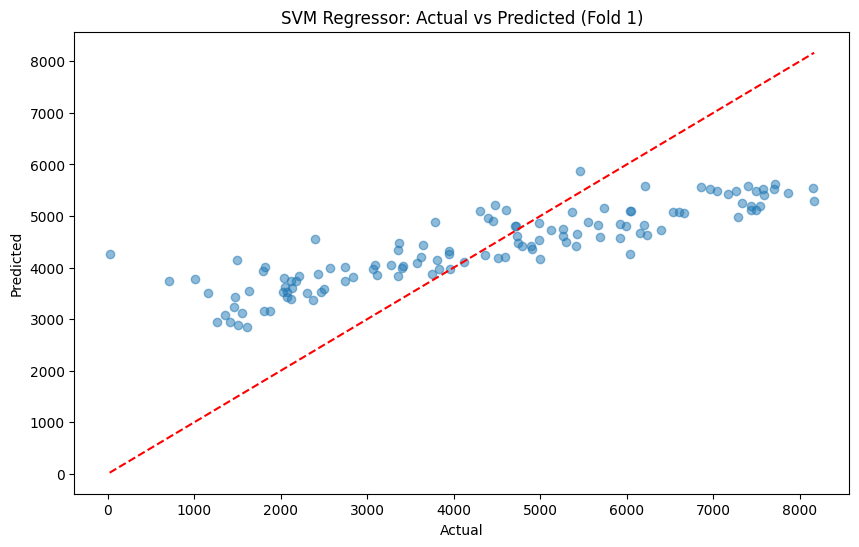


Average results across all folds:
Average MSE: 1878274.7652 ± 181916.3912
Average R²: 0.4910 ± 0.0253
Average Execution time: 0.0103 ± 0.0016 seconds


In [35]:
# Run Linear SVM Regressor
print("Linear SVM Regressor on Bike Sharing Dataset:")
svm_regressor_results = evaluate_svm_regressor(
    X_bike_scaled, 
    y_bike.values,
    n_folds=6
)

### Part 4 Results Summary

The linear SVM regressor has been evaluated on the Bike Sharing dataset using 6-fold cross-validation. The results show the regressor's performance in terms of Mean Squared Error (MSE), R² score, and execution time.

The scatter plot shows the relationship between actual and predicted values for the first fold, with the red dashed line representing perfect predictions. This helps visualize the model's performance.

## Part 5: Decision Tree Classifier

In this part, we implement a classifier based on Decision Trees and test it on the Breast Cancer dataset.
We'll experiment with two different pruning strategies.

In [43]:
from sklearn.tree import _tree
def extract_rules(tree, feature_names, class_names):
    """Extract rules from a decision tree"""
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    paths = []
    path = []
    
    def recurse(node, path, paths):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            
            # Add left node (<=)
            path.append((name, "<=", threshold))
            recurse(tree_.children_left[node], path, paths)
            
            # Remove last item for the right branch
            path.pop()
            
            # Add right node (>)
            path.append((name, ">", threshold))
            recurse(tree_.children_right[node], path, paths)
            
            # Remove last item after both branches are processed
            path.pop()
        else:
            # Leaf node - get the class that has the majority
            class_idx = np.argmax(tree_.value[node])
            class_name = class_names[class_idx]
            paths.append((path.copy(), class_name))
            
    recurse(0, path, paths)
    
    # Convert to rules
    rules = []
    for path, class_name in paths:
        rule = "IF " + " AND ".join([f"{name} {inequality} {threshold:.4f}" for name, inequality, threshold in path])
        rule += f" THEN class = {class_name}"
        rules.append(rule)
    
    return rules

In [44]:
def evaluate_dt_classifier(X, y, feature_names, class_names=[0, 1], n_folds=6):
    # Initialize KFold
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Initialize metrics storage for different pruning strategies
    results = {
        'no_pruning': {
            'accuracies': [],
            'times': [],
            'model': None
        },
        'max_depth': {
            'accuracies': [],
            'times': [],
            'model': None
        },
        'min_samples_leaf': {
            'accuracies': [],
            'times': [],
            'model': None
        }
    }
    
    # For each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train with no pruning
        start_time = time.time()
        dt_no_pruning = tree.DecisionTreeClassifier(random_state=42)
        dt_no_pruning.fit(X_train, y_train)
        y_pred_no_pruning = dt_no_pruning.predict(X_test)
        end_time = time.time()
        
        acc_no_pruning = accuracy_score(y_test, y_pred_no_pruning)
        time_no_pruning = end_time - start_time
        
        # Train with max_depth pruning
        start_time = time.time()
        dt_max_depth = tree.DecisionTreeClassifier(max_depth=5, random_state=42)
        dt_max_depth.fit(X_train, y_train)
        y_pred_max_depth = dt_max_depth.predict(X_test)
        end_time = time.time()
        
        acc_max_depth = accuracy_score(y_test, y_pred_max_depth)
        time_max_depth = end_time - start_time
        
        # Train with min_samples_leaf pruning
        start_time = time.time()
        dt_min_samples = tree.DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
        dt_min_samples.fit(X_train, y_train)
        y_pred_min_samples = dt_min_samples.predict(X_test)
        end_time = time.time()
        
        acc_min_samples = accuracy_score(y_test, y_pred_min_samples)
        time_min_samples = end_time - start_time
        
        # Store metrics
        results['no_pruning']['accuracies'].append(acc_no_pruning)
        results['no_pruning']['times'].append(time_no_pruning)
        
        results['max_depth']['accuracies'].append(acc_max_depth)
        results['max_depth']['times'].append(time_max_depth)
        
        results['min_samples_leaf']['accuracies'].append(acc_min_samples)
        results['min_samples_leaf']['times'].append(time_min_samples)
        
        # Store models for first fold
        if fold == 0:
            results['no_pruning']['model'] = dt_no_pruning
            results['max_depth']['model'] = dt_max_depth
            results['min_samples_leaf']['model'] = dt_min_samples
            
            print(f"Fold 1 results:")
            print(f"Training/test split: {len(X_train)}/{len(X_test)} samples")
            print("\nNo Pruning:")
            print(f"Tree size (number of nodes): {dt_no_pruning.tree_.node_count}")
            print(f"Maximum depth: {dt_no_pruning.tree_.max_depth}")
            print(f"Accuracy: {acc_no_pruning:.4f}")
            print(f"Execution time: {time_no_pruning:.4f} seconds")
            
            print("\nMax Depth Pruning (max_depth=5):")
            print(f"Tree size (number of nodes): {dt_max_depth.tree_.node_count}")
            print(f"Maximum depth: {dt_max_depth.tree_.max_depth}")
            print(f"Accuracy: {acc_max_depth:.4f}")
            print(f"Execution time: {time_max_depth:.4f} seconds")
            
            print("\nMin Samples Leaf Pruning (min_samples_leaf=5):")
            print(f"Tree size (number of nodes): {dt_min_samples.tree_.node_count}")
            print(f"Maximum depth: {dt_min_samples.tree_.max_depth}")
            print(f"Accuracy: {acc_min_samples:.4f}")
            print(f"Execution time: {time_min_samples:.4f} seconds")
    
    # Print average metrics
    print("\nAverage results across all folds:")
    print(f"No Pruning - Average Accuracy: {np.mean(results['no_pruning']['accuracies']):.4f} ± {np.std(results['no_pruning']['accuracies']):.4f}")
    print(f"Max Depth Pruning - Average Accuracy: {np.mean(results['max_depth']['accuracies']):.4f} ± {np.std(results['max_depth']['accuracies']):.4f}")
    print(f"Min Samples Leaf Pruning - Average Accuracy: {np.mean(results['min_samples_leaf']['accuracies']):.4f} ± {np.std(results['min_samples_leaf']['accuracies']):.4f}")
    
    # Extract rules from the best pruning strategy model of the first fold
    best_strategy = max(['no_pruning', 'max_depth', 'min_samples_leaf'], 
                        key=lambda x: np.mean(results[x]['accuracies']))
    
    print(f"\nExtracting rules from the best model: {best_strategy}")
    best_model = results[best_strategy]['model']
    rules = extract_rules(best_model, feature_names, class_names)
    
    print(f"Number of rules: {len(rules)}")
    print("Sample rules (first 5):")
    for i, rule in enumerate(rules[:5]):
        print(f"Rule {i+1}: {rule}")
    
    # Visualize the best tree if it's small enough
    if best_model.tree_.node_count < 50:  # Only visualize if tree is not too large
        plt.figure(figsize=(20, 10))
        tree.plot_tree(best_model, feature_names=feature_names, class_names=[str(c) for c in class_names], filled=True)
        plt.title(f"Decision Tree Visualization ({best_strategy})")
        plt.show()
    
    return results, rules

Decision Tree Classifier on Breast Cancer Dataset:
Fold 1 results:
Training/test split: 474/95 samples

No Pruning:
Tree size (number of nodes): 33
Maximum depth: 7
Accuracy: 0.9263
Execution time: 0.0078 seconds

Max Depth Pruning (max_depth=5):
Tree size (number of nodes): 27
Maximum depth: 5
Accuracy: 0.9263
Execution time: 0.0072 seconds

Min Samples Leaf Pruning (min_samples_leaf=5):
Tree size (number of nodes): 25
Maximum depth: 6
Accuracy: 0.9579
Execution time: 0.0055 seconds

Average results across all folds:
No Pruning - Average Accuracy: 0.9402 ± 0.0146
Max Depth Pruning - Average Accuracy: 0.9367 ± 0.0121
Min Samples Leaf Pruning - Average Accuracy: 0.9543 ± 0.0131

Extracting rules from the best model: min_samples_leaf
Number of rules: 13
Sample rules (first 5):
Rule 1: IF feature_8 <= 0.0609 AND feature_21 <= 0.1161 AND feature_14 <= 0.0608 AND feature_22 <= 0.7275 THEN class = Benign (0)
Rule 2: IF feature_8 <= 0.0609 AND feature_21 <= 0.1161 AND feature_14 <= 0.0608 AND

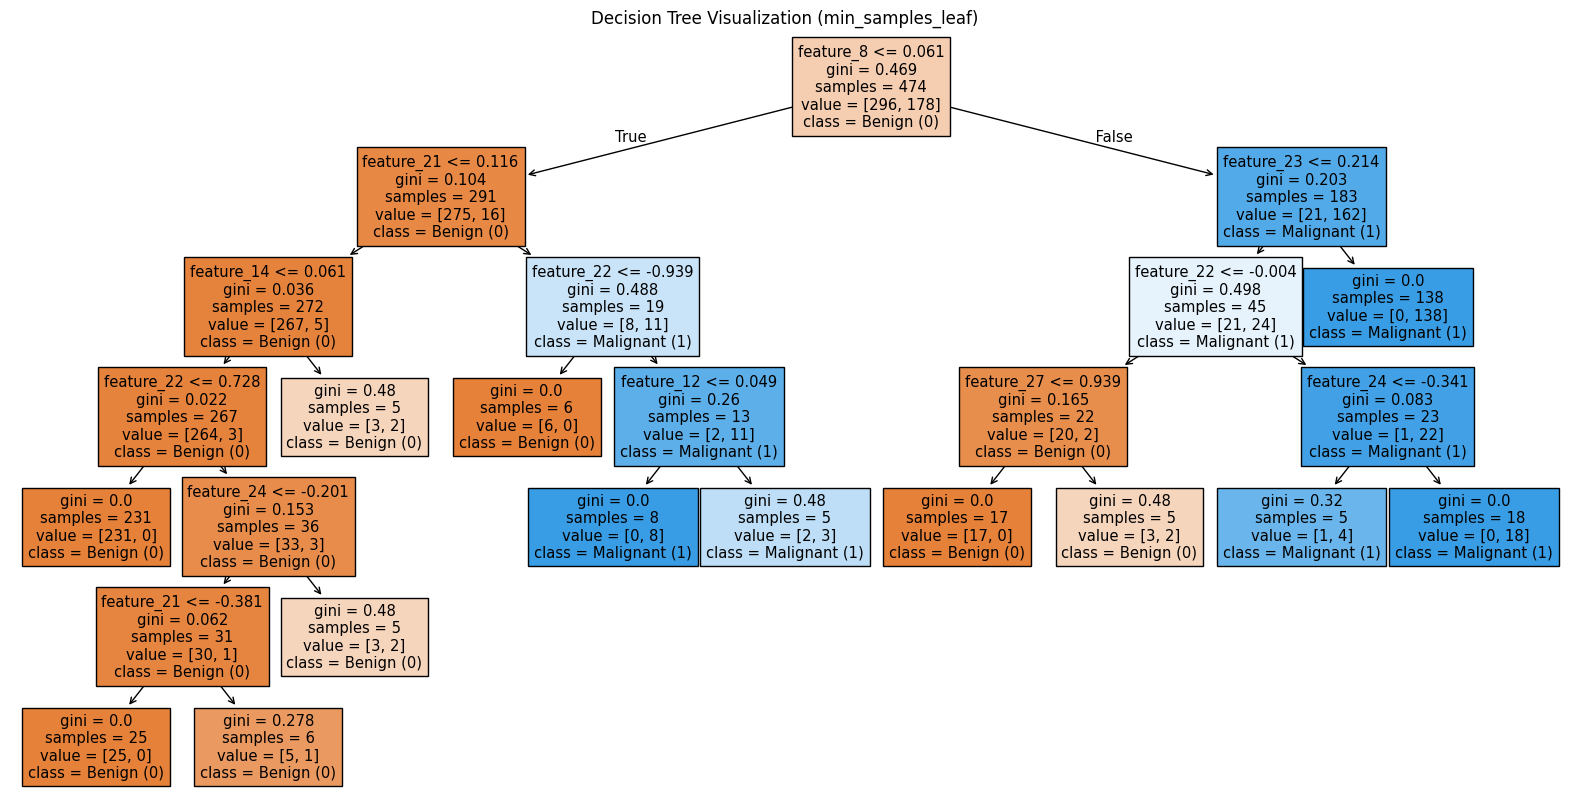

In [45]:
# Set feature names for the breast cancer dataset
cancer_feature_names = X_cancer.columns.tolist()

# Run Decision Tree Classifier
print("Decision Tree Classifier on Breast Cancer Dataset:")
dt_classifier_results, dt_rules = evaluate_dt_classifier(
    X_cancer_scaled, 
    y_cancer.values,
    feature_names=cancer_feature_names,
    class_names=['Benign (0)', 'Malignant (1)'],
    n_folds=6
)

### Part 5 Results Summary

The Decision Tree classifier has been evaluated on the Breast Cancer Wisconsin dataset using 6-fold cross-validation. We experimented with two different pruning strategies:

1. **Max Depth Pruning**: This strategy limits the maximum depth of the tree to 5 levels, preventing the tree from growing too deep and potentially overfitting. This reduces the complexity of the model and can improve generalization.

2. **Min Samples Leaf Pruning**: This strategy requires each leaf node to have at least 5 samples, which prevents the creation of very specific rules based on just a few training examples. This also helps prevent overfitting.

We also included a baseline model with no pruning to compare the effectiveness of the pruning strategies.

Additionally, we've extracted decision rules from the best-performing model. These rules provide a human-readable interpretation of the model's decision-making process, making it easier to understand how the model classifies samples.

## Part 6: Decision Tree Regressor

In this part, we implement a regressor based on Decision Trees and test it on the Bike Sharing dataset.

In [46]:
def extract_regression_rules(tree, feature_names):
    """Extract rules from a regression tree"""
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    paths = []
    path = []
    
    def recurse(node, path, paths):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            
            # Add left node (<=)
            path.append((name, "<=", threshold))
            recurse(tree_.children_left[node], path, paths)
            
            # Remove last item for the right branch
            path.pop()
            
            # Add right node (>)
            path.append((name, ">", threshold))
            recurse(tree_.children_right[node], path, paths)
            
            # Remove last item after both branches are processed
            path.pop()
        else:
            # Leaf node - get the prediction value
            value = tree_.value[node][0][0]  # Mean value of samples in this leaf
            paths.append((path.copy(), value))
            
    recurse(0, path, paths)
    
    # Convert to rules
    rules = []
    for path, value in paths:
        rule = "IF " + " AND ".join([f"{name} {inequality} {threshold:.4f}" for name, inequality, threshold in path])
        rule += f" THEN value = {value:.4f}"
        rules.append(rule)
    
    return rules

In [ ]:
def evaluate_dt_regressor(X, y, feature_names, n_folds=6):
    # Initialize KFold
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Initialize metrics storage
    mse_scores = []
    r2_scores = []
    times = []
    best_model = None
    best_fold_r2 = -float('inf')
    
    # For each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train regressor
        start_time = time.time()
        dt = tree.DecisionTreeRegressor(max_depth=10, random_state=42)
        dt.fit(X_train, y_train)
        
        # Predict
        y_pred = dt.predict(X_test)
        end_time = time.time()
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        execution_time = end_time - start_time
        
        # Store metrics
        mse_scores.append(mse)
        r2_scores.append(r2)
        times.append(execution_time)
        
        # Keep track of the best model
        if r2 > best_fold_r2:
            best_fold_r2 = r2
            best_model = dt
        
        # Print metrics for the first fold (as required)
        if fold == 0:
            print(f"Fold 1 results:")
            print(f"Training/test split: {len(X_train)}/{len(X_test)} samples")
            print(f"Tree size (number of nodes): {dt.tree_.node_count}")
            print(f"Maximum depth: {dt.tree_.max_depth}")
            print(f"Mean Squared Error (MSE): {mse:.4f}")
            print(f"R² Score: {r2:.4f}")
            print(f"Execution time: {execution_time:.4f} seconds")
            
            # Plot actual vs predicted for the first fold
            plt.figure(figsize=(10, 6))
            plt.scatter(y_test, y_pred, alpha=0.5)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
            plt.xlabel('Actual')
            plt.ylabel('Predicted')
            plt.title('Decision Tree Regressor: Actual vs Predicted (Fold 1)')
            plt.show()
    
    # Print average metrics
    print("\nAverage results across all folds:")
    print(f"Average MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
    print(f"Average R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    print(f"Average Execution time: {np.mean(times):.4f} ± {np.std(times):.4f} seconds")
    
    # Extract rules from the best model
    print(f"\nExtracting rules from the best model (fold with highest R²)")
    rules = extract_regression_rules(best_model, feature_names)
    
    print(f"Number of rules: {len(rules)}")
    print("Sample rules (first 5):")
    for i, rule in enumerate(rules[:5]):
        print(f"Rule {i+1}: {rule}")
    
    # Visualize tree if it's small enough
    if best_model.tree_.node_count < 50:  # Only visualize if tree is not too large
        plt.figure(figsize=(20, 10))
        tree.plot_tree(best_model, feature_names=feature_names, filled=True)
        plt.title("Decision Tree Regression Visualization")
        plt.show()
    
    return {
        'mse_scores': mse_scores,
        'r2_scores': r2_scores,
        'times': times,
        'rules': rules,
        'best_model': best_model
    }

In [ ]:
# Set feature names for the bike sharing dataset
bike_feature_names = X_bike.columns.tolist()

# Run Decision Tree Regressor
print("Decision Tree Regressor on Bike Sharing Dataset:")
dt_regressor_results = evaluate_dt_regressor(
    X_bike_scaled, 
    y_bike.values,
    feature_names=bike_feature_names,
    n_folds=6
)

### Part 6 Results Summary

The Decision Tree regressor has been evaluated on the Bike Sharing dataset using 6-fold cross-validation. We've configured the model with a maximum depth of 10 to prevent overfitting while still allowing it to capture the underlying patterns in the data.

The model's performance has been assessed using Mean Squared Error (MSE) and R² score metrics, which provide insights into both the absolute prediction errors and the proportion of variance explained by the model.

We've also extracted regression rules from the best-performing model (the one with the highest R² score). These rules provide a transparent representation of how the model makes predictions, showing the conditions that lead to different bike rental count predictions.

## Conclusions

In this assignment, we've implemented and evaluated various machine learning algorithms for classification and regression tasks:

1. **KNN Classifier with Euclidean distance**: We implemented a custom KNN classifier and evaluated it on the Breast Cancer dataset. The model demonstrated its ability to effectively classify tumors as benign or malignant.

2. **KNN Regressor with Manhattan distance**: Our custom KNN regressor was tested on the Bike Sharing dataset, showing how the k-nearest neighbors approach can be applied to regression problems.

3. **Linear SVM Classifier**: We utilized scikit-learn's SVM implementation for classification on the Breast Cancer dataset, examining the model's performance using ROC curves and finding optimal decision thresholds.

4. **Linear SVM Regressor**: We applied SVR to the Bike Sharing dataset, demonstrating how support vector methods can be extended to regression problems.

5. **Decision Tree Classifier**: We experimented with different pruning strategies (max depth and min samples leaf) to understand their impact on model complexity and performance for the Breast Cancer dataset.

6. **Decision Tree Regressor**: We applied decision trees to the regression task with the Bike Sharing dataset and extracted human-readable rules from the model.

For each model, we reported performance metrics, execution times, and visual representations of the results. We also implemented rule extraction for decision tree models, providing interpretable insights into the models' decision-making processes.

This comprehensive evaluation provides a solid foundation for understanding the strengths and weaknesses of each algorithm in different contexts, as well as the impact of various parameter choices and pruning strategies on model performance.